In [1]:
import os

import cv2

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from PIL import Image
from logwriter import Logger

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class PokemonDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file_list = []
        
        for root, directory, filenames in os.walk(data_dir):
            for filename in filenames:
                if filename.endswith("png"):
                    self.file_list.append(os.path.join(root, filename))
        
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = Image.open(self.file_list[idx]).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
#         if not all(image[:, 0, 0] == 0):
#             os.remove(self.file_list[idx])
            
        return image

In [4]:
data_dir = './sprites/sprites/pokemon'
image_size = 128
batch_size = 64

pokemon_dataset = PokemonDataset(data_dir, 
                                 transform=transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]))

pokemon_dataloader = DataLoader(pokemon_dataset, shuffle=True, batch_size=batch_size)
dataloader_size = len(pokemon_dataloader)
print(dataloader_size)

60


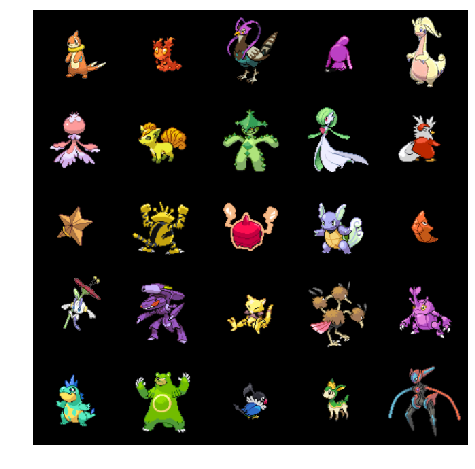

In [5]:
def show_images(images, n_images, nrow=5):
    plt.figure(figsize=(15, 8))
    plt.imshow(torchvision.utils.make_grid(images.data[:n_images], 
                                           normalize=True, 
                                           scale_each=True, 
                                           padding=0, 
                                           nrow=nrow).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
images = next(iter(pokemon_dataloader))
show_images(images, 25)

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, image_size=128, n_channels=3):
        super(Generator, self).__init__()
        
        self.input_size = input_size
        self.init_size = np.ceil(image_size / 16).astype(int)
        
        self.fc1 = nn.Sequential(
            nn.Linear(self.input_size, 256 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.ConvTranspose2d(32, n_channels, kernel_size=(5, 5), stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(n_channels),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        hidden = self.fc1(z)
        hidden = hidden.view(-1, 256, self.init_size, self.init_size)
        hidden = self.conv_block1(hidden)
        
        hidden = self.conv_block2(hidden)
        
        hidden = self.conv_block3(hidden)
        
        hidden = self.conv_block4(hidden)
        return hidden

In [7]:
class Discriminator(nn.Module):
    def __init__(self, image_size, n_channels=3):
        super(Discriminator, self).__init__()
        
        self.image_size = image_size
        self.fc_size = np.ceil(self.image_size / 16).astype(int)
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=(5, 5), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 216, kernel_size=(5, 5), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(216),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(216 * self.fc_size * self.fc_size, 1)
        )
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        conv1 = self.conv_block1(x)
        
        conv2 = self.conv_block2(conv1)
        
        conv3 = self.conv_block3(conv2)
        
        conv4 = self.conv_block4(conv3)
        fc_in = conv4.view(-1, 216 * self.fc_size * self.fc_size)
        
        output = self.fc(torch.cat((fc_in, OX), 1))
        
        return output

In [8]:
n_epochs = 5000
generator_lr = 1e-4
discriminator_lr = 1e-4
g_iters = 1
d_iters = 1
threshold = 1
c = 0.01

generator = Generator(100, image_size, n_channels=3).to(device)
discriminator = Discriminator(image_size, n_channels=3).to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=generator_lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))

adversarial_loss = torch.nn.BCEWithLogitsLoss()
feature_loss = torch.nn.MSELoss()

logger = Logger(f'pokemon_dcgan_epoch{n_epochs}_g{generator_lr}_d{discriminator_lr}_batchsize{batch_size}',
                'Added minibatch discrimination.')
logger.get_run_command()

'tensorboard --logdir=C:\\Users\\Jonathan\\Documents\\development\\gan/runs/pokemon_dcgan_epoch5000_g0.0001_d0.0001_batchsize64/Nov-14-2018-16h21m57s/ --host=127.0.0.1'

In [9]:
# generator.load_state_dict(torch.load('./checkpoints/generator'))
# discriminator.load_state_dict(torch.load('./checkpoints/discriminator'))

[Epoch 0 / 5000] G_loss: 1.4643; D_loss: 0.6981


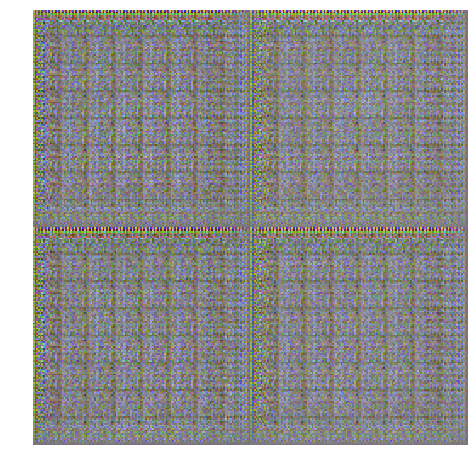

KeyboardInterrupt: 

In [11]:
for epoch in range(n_epochs):
    running_d_loss = 0
    running_g_loss = 0
    for images in pokemon_dataloader:
        images = images.to(device)
        
        # One sided label smoothing
        real = Variable(torch.tensor([[0.9]] * images.shape[0], device=device), requires_grad=False)
        fake = Variable(torch.tensor([[0.1]] * images.shape[0], device=device), requires_grad=False)

        for _ in range(g_iters):
            optimizer_g.zero_grad()
            z = Variable(torch.cuda.FloatTensor(np.random.randn(images.shape[0], 100), device=device))

            generated_images = generator(z)

            gen_logits = discriminator(generated_images)
            g_loss = adversarial_loss(gen_logits, real)
            g_loss.backward()
            optimizer_g.step()

        
        for _ in range(d_iters):
            optimizer_d.zero_grad()
            real_logits = discriminator(images)
            fake_logits = discriminator(generated_images.detach())
            
            d_loss = adversarial_loss(real_logits, real) + adversarial_loss(fake_logits, fake)
            
            d_loss.backward()
            optimizer_d.step()

        logger.log(g_loss, 'G_loss')        
        logger.log(d_loss, 'D_loss')        

        if logger.get_step() % 200 == 0:
            logger.log_image(generated_images.data, 'images', 16)
        logger.step()
            
    torch.save(generator.state_dict(), './checkpoints/generator')    
    torch.save(discriminator.state_dict(), './checkpoints/discriminator')
    
    if epoch % 30 == 0:
        print(f'[Epoch {epoch} / {n_epochs}] G_loss: {g_loss:.4f}; D_loss: {d_loss:.4f}')
        show_images(generated_images, 4, 2)